在时间序列分析中，描述了如何通过协整的方式寻找可以配对交易的组合，本节在此基础上实现自动脚本运行，找到相关性高的股票。

In [62]:
import os
import requests,re
import akshare as ak
import statsmodels.api as sm
import pandas as pd
import statsmodels.tsa.stattools as ts
from queue import PriorityQueue
import seaborn as sns
import matplotlib.dates as mdates
from matplotlib import pyplot as plt
import numpy as np

## 1.如何获取股票集合

In [3]:
# 1.1通过三方网站，获取a股集合,股票很多，会有点慢
response = requests.get("http://www.shdjt.com/js/lib/astock.js")
astock = re.findall(r"~([a-z0-9]*)`", response.text)
print(len(astock))
print(astock[0:5])

7817
['000001', '000002', '000003', '000004', '000005']


In [34]:
# 1.2 通过akshare 获取成分股
## https://akshare.akfamily.xyz/data/index/index.html#id16
## 获取新浪沪深300 
index_stock_cons_df = ak.index_stock_cons(symbol="000300")
print("==========》沪深300")
print(index_stock_cons_df[0:3])
## 获取中证指数沪深300
print("==========》中证指数沪深300")
index_stock_cons_csindex_df = ak.index_stock_cons_csindex(symbol="000300")
#print(index_stock_cons_csindex_df[['成分券代码','成分券名称']])
## 获取成分权重
index_stock_cons_weight_csindex_df = ak.index_stock_cons_weight_csindex(symbol="000300")
print(index_stock_cons_weight_csindex_df[['成分券代码','成分券名称','权重']][0:3])

==========》沪深300
     品种代码  品种名称        纳入日期
0  601916  浙商银行  2023-12-11
1  301269  华大九天  2023-12-11
2  688256   寒武纪  2023-12-11
==========》中证指数沪深300
    成分券代码 成分券名称     权重
0  000001  平安银行  0.524
1  000002   万科A  0.410
2  000063  中兴通讯  0.486


## 2. 通过股票集合获取行情

In [33]:
## 2.1 以沪深300股票为例
##### 使用akshare 获取股票历史行情，adjust	str	默认返回不复权的数据; qfq: 返回前复权后的数据; hfq: 返回后复权后的数据
stock_zh_a_hist_df = ak.stock_zh_a_hist(symbol="000001", period="daily", start_date="20230301", end_date='20230907', adjust="")
print(stock_zh_a_hist_df[:3])

           日期     开盘     收盘     最高     最低      成交量           成交额    振幅   涨跌幅  \
0  2023-03-01  13.80  14.17  14.19  13.74  1223452  1.719711e+09  3.27  2.83   
1  2023-03-02  14.13  14.24  14.44  14.06  1015877  1.447566e+09  2.68  0.49   
2  2023-03-03  14.35  14.29  14.37  14.14   690954  9.855521e+08  1.62  0.35   

    涨跌额   换手率  
0  0.39  0.63  
1  0.07  0.52  
2  0.05  0.36  


In [36]:
## 2.2 使这里使用停牌的股票测试一下，如果存在某个单一股票停牌，则删除对应的数据不做比较， 603023 20230711有停牌
astock = ak.stock_zh_a_hist(symbol='603023', period="daily", start_date="20220101", end_date='20231231', adjust="hfq")
astock.index = astock['日期']
bstock = ak.stock_zh_a_hist(symbol='601916', period="daily", start_date="20220101", end_date='20231231', adjust="hfq")
bstock.index = bstock['日期']
combination = pd.DataFrame()
combination['astock'] = astock['收盘']
combination['abtock'] = bstock['收盘']
print("603023的数据量:",len(astock))
print("601916的数据量:",len(bstock))
combination.dropna()
print("删除空值之后的数据量:",len(combination))

603023的数据量: 474
601916的数据量: 478
删除空值之后的数据量: 474


In [37]:
## 2.3 foreach stock to get quote, and set to quote dict, time will be a little long
quote_dict = {}
for stock in index_stock_cons_df['品种代码']:
    stock_zh_a_hist_df = ak.stock_zh_a_hist(symbol=stock, period="daily", start_date="20220101", end_date='20231231', adjust="hfq")
    stock_zh_a_hist_df.index = stock_zh_a_hist_df['日期']
    quote_dict[stock] = stock_zh_a_hist_df

In [38]:
## 2.4 look for relative stock pair, there are 300 stocks, each combination include 2 stock , 300*(300-1)/2 = 44850
### 2.4.1 构建所有的组合
#print(len(quote_dict))
all_combinations=[]
hs300 = index_stock_cons_df['品种代码']
print("沪深300股票的数据量",len(hs300))
for i in range(len(hs300) - 1):
    for j in range(i + 1,len(hs300)) :
        all_combinations.append(hs300[i]+','+hs300[j])
        #print(hs300[i],',',hs300[j])
print("沪深300每2个股票构成一个集合的数据量",len(all_combinations))

沪深300股票的数据量 300
沪深300每2个股票构成一个集合的数据量 44850


## 3. 计算CADF

In [42]:
# calculate cadf, get cadf val
# cadf 参数的含义见时间序列分析部分
def calculate_cadf(stock_combination):
    # 分离股票代码
    stock_vec = stock_combination.split(',')
    if len(stock_vec) != 2:
        print('unknown stock_combination', stock_combination)
        return
    stock1 = stock_vec[0]
    stock2 = stock_vec[1]
    # 构建新的组合
    stock_combination = pd.DataFrame()
    stock_combination[stock1] = quote_dict[stock1]['收盘']
    stock_combination[stock2] = quote_dict[stock2]['收盘']
    # 删除空值
    stock_combination = stock_combination.dropna()
    #print(stock_combination)
    ## 进行OLS 训练，寻找参数
    model = sm.OLS(stock_combination[stock1], stock_combination[stock2])
    res= model.fit()
#     print(res.params[0])
#     print(res.summary())
    stock_combination["res"] = stock_combination[stock1] - res.params[0] *stock_combination[stock2]
#     #print(df["res"])
    # 获取参数结果
    cadf = ts.adfuller(stock_combination["res"])
    if cadf[1] >= 0.001 or cadf[0] > cadf[4]['1%']:
        return False, 0, cadf[1]
#     print(cadf)
#     print(cadf[0])
#     print(cadf[1])
#     print(cadf[4]['1%'])
    return True, cadf[0],cadf[1]

calculate_cadf('601916,301269')

(False, 0, 0.01565804329401019)

In [45]:
# 获取计算结果，放在优先队列中
cadf_pq = PriorityQueue()
## 数据接近50000个组合，只运行10000个组合，看看结果
for combination in all_combinations[0:10000]:
#     print(combination)
    cadfPassed, tStat , pValue= calculate_cadf(combination)
    if cadfPassed:
        #print(tStat, combination)
        cadf_pq.put((tStat,pValue, combination))

/Users/neil/anaconda3/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:940: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


In [50]:
# 获取到前10组股票
for i in range(10):
    print(cadf_pq.get())

(-6.10279795196737, 9.743996556382118e-08, '600674,300433')
(-5.923899040209228, 2.469527406422219e-07, '601699,300433')
(-5.617043137434816, 1.1679665215196353e-06, '600023,300433')
(-5.314153220357734, 5.117872580870923e-06, '600803,600011')
(-5.139567355684046, 1.1665725327115197e-05, '000983,002475')
(-5.124443400485768, 1.2516222555184482e-05, '600039,300433')
(-5.086955736567507, 1.4890852108722185e-05, '600372,000661')
(-5.0737055834075315, 1.5830009880242826e-05, '600515,002603')
(-5.0499788575149696, 1.7656566807224052e-05, '600803,300413')
(-5.010266453862187, 2.11779429744831e-05, '002603,002352')


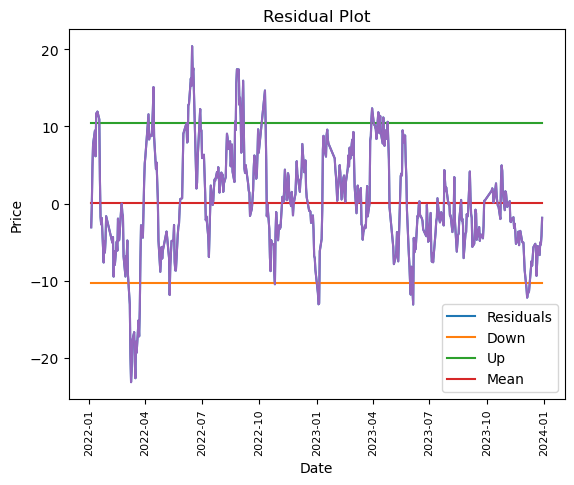

In [77]:
def plot_residuals(stock_combination):
    stock_vec = stock_combination.split(',')
    if len(stock_vec) != 2:
        print('unknown stock_combination', stock_combination)
        return
    stock1 = stock_vec[0]
    stock2 = stock_vec[1]
    stock_combination = pd.DataFrame()
    stock_combination[stock1] = quote_dict[stock1]['收盘']
    stock_combination[stock2] = quote_dict[stock2]['收盘']
    # 删除空值
    stock_combination = stock_combination.dropna()
    #print(stock_combination)
    ## 进行OLS 训练，寻找参数
    model = sm.OLS(stock_combination[stock1], stock_combination[stock2])
    res= model.fit()
    stock_combination["res"] = stock_combination[stock1] - res.params[0] *stock_combination[stock2]
    mean=np.mean(stock_combination["res"])
    std=np.std(stock_combination["res"])
    up=mean+1.5*std
    down=mean-1.5*std
    mean_line=pd.Series(mean,index=stock_combination.index)
    up_line=pd.Series(up,index=stock_combination.index)
    down_line=pd.Series(down,index=stock_combination.index)
    stock_combination["res"]
    months = mdates.MonthLocator() # every month 
    fig, ax = plt.subplots()
    ax.plot(stock_combination.index, stock_combination["res"], label="Residuals")
    ax.plot(stock_combination.index, down_line, label="Down")
    ax.plot(stock_combination.index, up_line, label="Up")
    ax.plot(stock_combination.index, mean_line, label="Mean")
    gap = 10
    plt.ylabel('Price')
    plt.xlabel('Date')
    plt.xticks(rotation=90, size=8)
    plt.title('Residual Plot')
    plt.legend()
    plt.plot(stock_combination["res"])
    plt.show()

plot_residuals('600803,600011')

可以看到在1.5 个标准差的时候，是可以来回做套利的，价格在Up 和Down 之间振动，最后总是回到均值附近。

##### 上面的过程存在哪些问题： 
Question1: 有些股票，比如浙商银行是2023-12-11 才纳入的000300， 但用于统计相关性的数据起始时间是20220101，属于使用了未来函数，因为这里只是计算股票之间的相关性，和指数成分之间关系不大，但如果基于股票池的回测中使用了这组数据呢？
Question2: 股票价格是不一样的,两个股票分别应该交易的单位是多少才能构成配对？